# Imports

In [29]:
# %pip install gdown --no-cache-dir --upgrade

In [30]:
# !gdown 1b4LsX6ybLewRxjx1MrWFsGuAWhkfugZ-

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import json


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from numpy import arange

from tqdm.auto import tqdm, trange
from warnings import filterwarnings

filterwarnings('ignore')

# Data preparation

In [32]:
DATASET_PATH = './PredictorData2018Fixed.xlsx'

In [33]:
df = pd.read_excel(DATASET_PATH)
df.head()

,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,unem,ltr,corpr,svar,csp,IndProd,CRSP_SPvw,CRSP_SPvwx
0,187101.0,4.44,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,187102.0,4.50,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187103.0,4.61,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,187104.0,4.74,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187105.0,4.86,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.003691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df = df[['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'ntis', 'tbl', 'lty', 'AAA', 'BAA', 'infl', 'svar']]

In [35]:
df = df.dropna(subset=['yyyymm'])

In [36]:
df = df.rename(columns={'yyyymm': 'date', 'b/m': 'b_m'})

df['date'] = df['date'].astype(int).astype(str).str.zfill(6)

df['date'] = pd.to_datetime(df['date'], format='%Y%m')

df.set_index('date', inplace=True)

In [37]:
df

,Index,D12,E12,b_m,ntis,tbl,lty,AAA,BAA,infl,svar
date,,,,,,,,,,,
1871-01-01,4.44,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-02-01,4.50,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-03-01,4.61,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-04-01,4.74,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-05-01,4.86,0.260000,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,2901.52,52.338996,130.39,0.229618,-0.021495,0.0203,0.0293,0.0388,0.0477,0.000556,0.000471
2018-09-01,2913.98,52.338996,130.39,0.225335,-0.020871,0.0213,0.0334,0.0398,0.0488,0.001162,0.000230
2018-10-01,2711.74,53.748178,132.39,0.237380,-0.021222,0.0225,0.0352,0.0414,0.0507,0.001767,0.004578


## Feature extraction Task 2


In [38]:
df_post_wwii = df['1950-01-01':]

In [39]:
df_post_wwii['log_return'] = np.log((df_post_wwii['Index'] + df_post_wwii['D12']/12) / df_post_wwii['Index'].shift(1))
df_post_wwii['target'] = df_post_wwii['log_return'].shift(-1)

In [40]:
df_post_wwii

,Index,D12,E12,b_m,ntis,tbl,lty,AAA,BAA,infl,svar,log_return,target
date,,,,,,,,,,,,,
1950-01-01,17.05,1.150000,2.33667,0.791417,0.027102,0.0107,0.0215,0.0257,0.0324,-0.004237,0.000989,NaN,0.015519
1950-02-01,17.22,1.160000,2.35333,0.784998,0.025492,0.0112,0.0214,0.0258,0.0324,0.000000,0.000426,0.015519,0.009680
1950-03-01,17.29,1.170000,2.37000,0.825528,0.029291,0.0112,0.0215,0.0258,0.0324,0.004255,0.000624,0.009680,0.049552
1950-04-01,18.07,1.180000,2.42667,0.796497,0.026398,0.0115,0.0214,0.0260,0.0323,0.000000,0.000714,0.049552,0.043806
1950-05-01,18.78,1.190000,2.48333,0.761346,0.028572,0.0116,0.0213,0.0261,0.0325,0.004237,0.000641,0.043806,-0.054156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,2901.52,52.338996,130.39000,0.229618,-0.021495,0.0203,0.0293,0.0388,0.0477,0.000556,0.000471,0.031316,0.005781
2018-09-01,2913.98,52.338996,130.39000,0.225335,-0.020871,0.0213,0.0334,0.0398,0.0488,0.001162,0.000230,0.005781,-0.070279
2018-10-01,2711.74,53.748178,132.39000,0.237380,-0.021222,0.0225,0.0352,0.0414,0.0507,0.001767,0.004578,-0.070279,0.019323


In [41]:
df_post_wwii['log_dividend_price_ratio'] = np.log(df_post_wwii['D12'] / df_post_wwii['Index'])
df_post_wwii['log_earning_price_ratio'] = np.log(df_post_wwii['E12'] / df_post_wwii['Index'])
df_post_wwii['dividend_payout_ratio'] = df_post_wwii['D12'] / df_post_wwii['E12']
df_post_wwii['term_spread'] = df_post_wwii['lty'] - df_post_wwii['tbl']
df_post_wwii['default_spread'] = df_post_wwii['AAA'] - df_post_wwii['BAA']
df_post_wwii['default_return_spread'] = df_post_wwii['AAA'] - df_post_wwii['lty']


### Visualization

In [42]:
sns.set_theme('paper')

#### Index plot

In [43]:
sns.set_style('darkgrid')
sns.set_theme('paper')

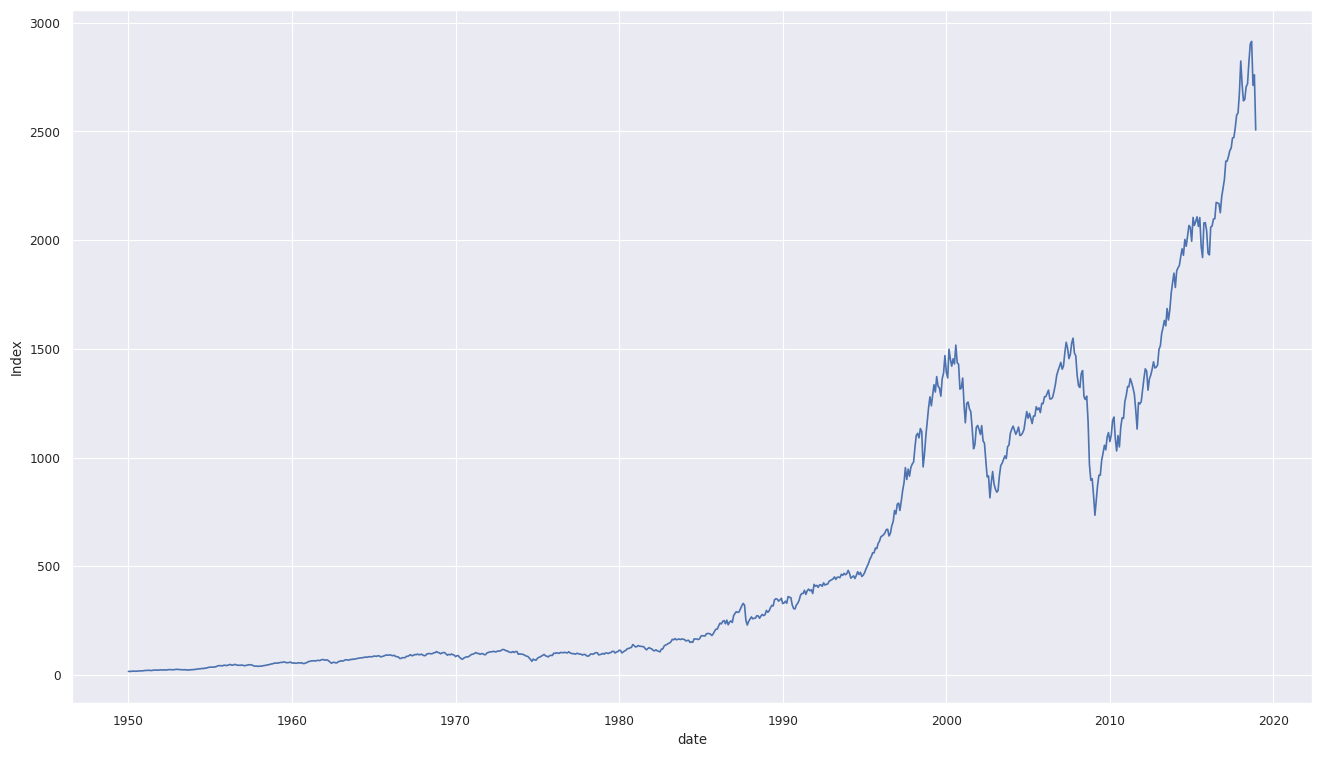

In [44]:
plt.figure(figsize=(16,9))
sns.lineplot(data=df_post_wwii, x='date', y='Index')
plt.savefig('plots/index_lineplot.pdf')

#### Pairplot

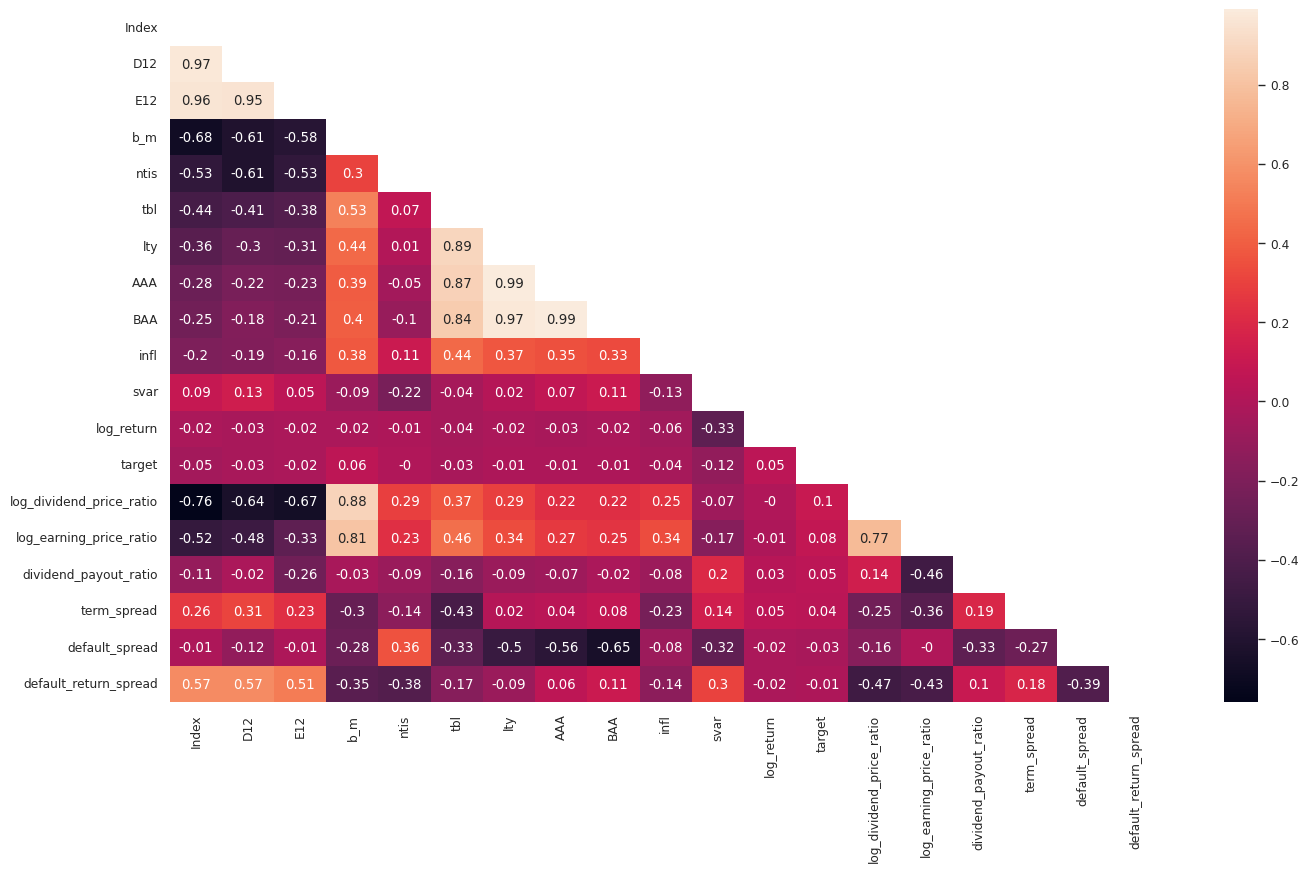

In [45]:
plt.figure(figsize=(16,9))
sns.set_style('white')
corr_matrix = df_post_wwii.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_triu = np.round(corr_matrix.mask(mask), 2)
# corr_matrix_triu
sns.heatmap(corr_matrix_triu, annot=True)
plt.grid(False)
plt.savefig('plots/corr_heatmap.pdf')



In [46]:
# sns.pairplot(df_post_wwii, diag_kind='hist')

#### Selecting time periods for the robustness check

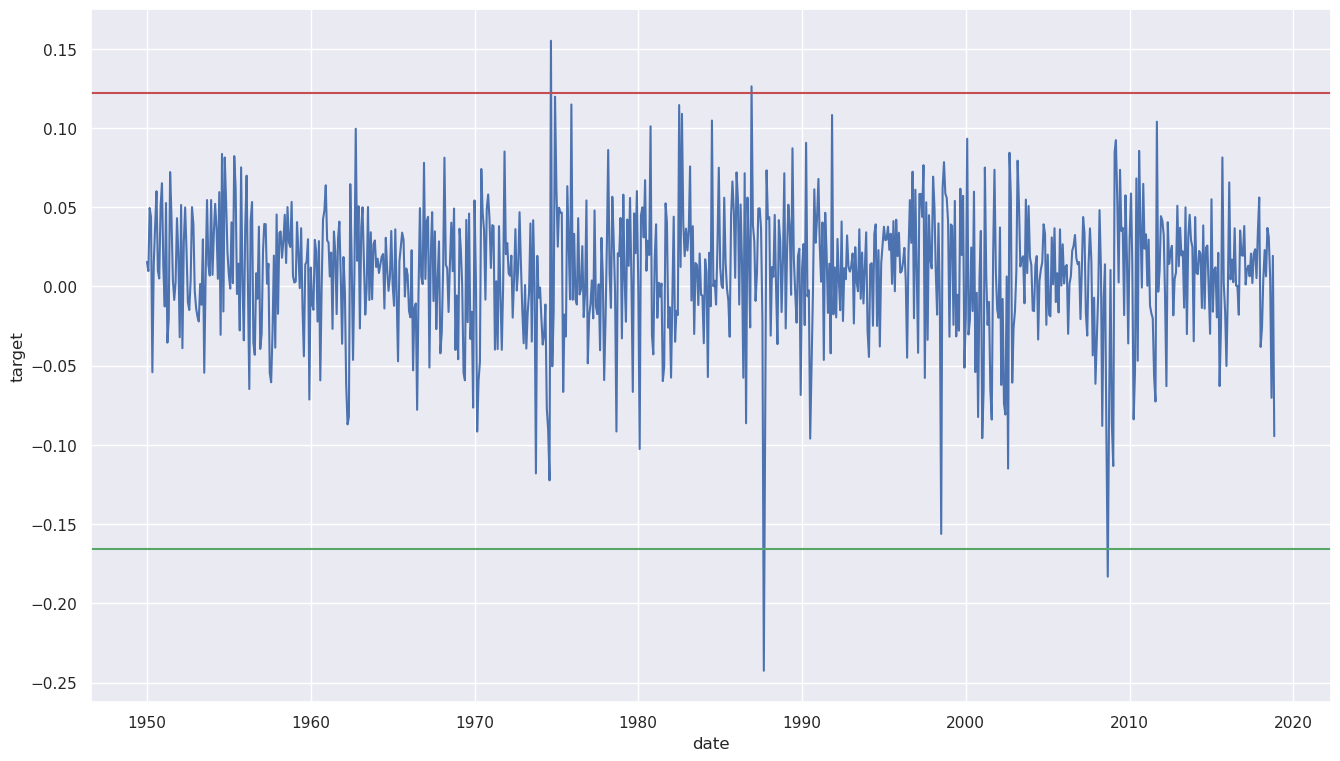

In [47]:
plt.figure(figsize=(16,9))
sns.set_theme('notebook')
sns.lineplot(data=df_post_wwii, x='date', y='target')
plt.axhline(np.percentile(df_post_wwii['target'].dropna(), 99.8), color='r')
plt.axhline(np.percentile(df_post_wwii['target'].dropna(), 0.2), color='g')

In [48]:
df_post_wwii['target'].describe()

count    827.000000
mean       0.008712
std        0.041337
min       -0.242550
25%       -0.014997
50%        0.011952
75%        0.036536
max        0.155087
Name: target, dtype: float64

In [49]:
# Higest scores for target
df_post_wwii[df_post_wwii['target'] > np.percentile(df_post_wwii['target'].dropna(), 99.8)]

,Index,D12,E12,b_m,ntis,tbl,lty,AAA,BAA,infl,svar,log_return,target,log_dividend_price_ratio,log_earning_price_ratio,dividend_payout_ratio,term_spread,default_spread,default_return_spread
date,,,,,,,,,,,,,,,,,,,
1974-09-01,63.54,3.59,9.11,1.135440,0.005138,0.0806,0.0837,0.0924,0.1018,0.012000,0.007812,-0.122380,0.155087,-2.873517,-1.942297,0.394072,0.0031,-0.0094,0.0087
1986-12-01,242.17,8.28,14.48,0.498431,-0.011376,0.0553,0.0789,0.0849,0.0997,0.000906,0.001262,-0.025851,0.126300,-3.375797,-2.816872,0.571823,0.0236,-0.0148,0.0060


In [50]:
# Higest scores for target
df_post_wwii[df_post_wwii['target'] <= np.percentile(df_post_wwii['target'].dropna(), 0.2)]

,Index,D12,E12,b_m,ntis,tbl,lty,AAA,BAA,infl,svar,log_return,target,log_dividend_price_ratio,log_earning_price_ratio,dividend_payout_ratio,term_spread,default_spread,default_return_spread
date,,,,,,,,,,,,,,,,,,,
1987-09-01,321.83,8.660,15.86,0.379967,0.006350,0.0640,0.0992,0.1018,0.1131,0.005245,0.002535,-0.022223,-0.242550,-3.615309,-3.010223,0.546028,0.0352,-0.0113,0.0026
2008-09-01,1166.36,28.854,45.95,0.287124,-0.050314,0.0113,0.0443,0.0565,0.0731,-0.001383,0.023775,-0.093121,-0.183171,-3.699394,-3.234089,0.627943,0.0330,-0.0166,0.0122


## OLS test

In [51]:
from statsmodels.formula.api import ols

In [52]:
model = ols(formula = 'target ~ log_dividend_price_ratio + log_earning_price_ratio + \
dividend_payout_ratio + svar + b_m  + ntis + tbl + lty + term_spread + \
default_spread + default_return_spread + infl', data = df_post_wwii)

result = model.fit()

In [53]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.437
Date:                Mon, 27 May 2024   Prob (F-statistic):           1.64e-06
Time:                        21:31:06   Log-Likelihood:                 1485.9
No. Observations:                 827   AIC:                            -2948.
Df Residuals:                     815   BIC:                            -2891.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0947      0.038      2.459      0.014       0.019       0.170
log_dividend_price_ratio    -0.0114      0.012     -0.921      0.357      -0.036       0.013
log_earning_price_ratio      0.0486      0.013      3.756      0.000       0.023       0.074
dividend_payout_ratio        0.0408      0.012      3.390      0.001       0.017       0.064
svar                        -1.6389      0.388     -4.229      0.000      -2.399      -0.878
b_m                         -0.0297      0.018     -1.688      0.092      -0.064       0.005
ntis                         0.0363      0.093      0.389      0.697      -0.147       0.219
tbl                         -0.0760      0.047     -1.623      0.105      -0.168       0.016
lty                          0.0558      0.062      0.898      0.369      -0.066       0.178
term_spread                  0.1318      0.084      1.574      0.116      -0.033       0.296
default_spread              -0.2083      0.617     -0.338      0.736      -1.419       1.002
default_return_spread        0.7776      0.475      1.637      0.102      -0.155       1.710
infl                        -0.9369      0.464     -2.019      0.044      -1.848      -0.026
==============================================================================
Omnibus:                       79.460   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.440
Skew:                          -0.521   Prob(JB):                     4.92e-44
Kurtosis:                       5.169   Cond. No.                     2.40e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.15e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
model = ols(formula = 'target ~ log_earning_price_ratio + \
dividend_payout_ratio + svar + b_m  + default_return_spread + infl', data = df_post_wwii)

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     7.326
Date:                Mon, 27 May 2024   Prob (F-statistic):           1.21e-07
Time:                        21:31:06   Log-Likelihood:                 1483.5
No. Observations:                 827   AIC:                            -2953.
Df Residuals:                     820   BIC:                            -2920.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1154      0.028      4.157      0.000       0.061       0.170
log_earning_price_ratio     0.0383      0.009      4.315      0.000       0.021       0.056
dividend_payout_ratio       0.0339      0.007      4.566      0.000       0.019       0.049
svar                       -1.5969      0.377     -4.235      0.000      -2.337      -0.857
b_m                        -0.0340      0.013     -2.544      0.011      -0.060      -0.008
default_return_spread       0.9642      0.393      2.454      0.014       0.193       1.735
infl                       -0.9545      0.425     -2.248      0.025      -1.788      -0.121
==============================================================================
Omnibus:                       79.578   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.167
Skew:                          -0.526   Prob(JB):                     1.53e-43
Kurtosis:                       5.149   Cond. No.                         976.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Task 3

In [55]:
post_wwii = df_post_wwii[['target', 'log_dividend_price_ratio', 'log_earning_price_ratio', 'dividend_payout_ratio', 'svar', 'b_m', 'ntis', 'tbl', 'lty', 'term_spread', 'default_spread',
                          'default_return_spread', 'infl']]

In [56]:
post_wwii = post_wwii.dropna(subset=['target'])

In [57]:
from sklearn.model_selection import train_test_split

In [22]:
def split_data(df, target_column='target', test_size=0.15, random_state=None):

    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

# Model training

## Helper Functions

In [59]:
def get_data_split(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        shuffle=False
    )
    return X_train, y_train, X_test, y_test

def manual_grid_search(
        X_train, y_train, X_test, y_test,
        estimator_class,
        param_grid,
        refit=True,
        scoring_function=mean_squared_error,
        tqdm_disable=True):
    """Find a best parameters for the model

    Args:
        X_train (_type_): _description_
        y_train (_type_): _description_
        X_test (_type_): _description_
        Y_test (_type_): _description_
        estimator_class (_type_): Model class to use class e.g. RandomForest.
        Do not initialize, just pass the class
        param_grid (dict): Dictionary of values like {'alpha': [0, 1, 2], 'beta' : [0, 1]}
        scoring_function (Callable, optional): A function to judge the performance of the model. Defaults to mean_squared_error.

    Returns:
        tuple: best_model, best_params, best_score
    """


    best_model = None
    best_score_on_test = float('inf')
    best_params = None

    # So that the proper order of keys is guaranteed
    keys, values = list(zip(*param_grid.items()))

    # Generate combinations of different parameters
    parameter_combinations = list(itertools.product(*values))

    # Loop thought each combination
    for parameter_set in tqdm(parameter_combinations, desc='Selecting best params...', disable=tqdm_disable):

        # Make a dict with parameter names and current combinartion
        # of parameters
        parameter_dict = dict(zip(keys, parameter_set))

        # Fit model
        model = estimator_class(**parameter_dict)
        model.fit(X_train, y_train)

        # Make prediction
        predictions = model.predict(X_test)

        # Calculate score
        current_score = scoring_function(y_test, predictions)

        if current_score < best_score_on_test:
            best_score_on_test = current_score
            best_model = model
            best_params = parameter_dict

    if refit:
        refit_model = estimator_class(**best_params)
        refit_model.fit(np.concatenate([
            X_train,
            X_test
        ]), np.concatenate([
            y_train,
            y_test
        ]))
        best_model = refit_model

    return best_model, best_params, best_score_on_test

def expanding_window_forecasts_with_custom_gridsearch(
        df,
        estimator_class,
        param_grid,
        normalize_data=True,
        scoring_function=mean_squared_error,
        target_column='target',
        start_date='1981-01-01',
        test_size=0.15):
    forecasts = []
    actuals = []
    dates = df.loc[start_date:].index
    for i in trange(len(dates) - 1):
        date = dates[i]
        next_date = dates[i + 1]

        df_subset = df.loc[:date]

        X = df_subset.drop(columns=[target_column])
        y = df_subset[target_column]

        X_train, y_train, X_test, y_test = get_data_split(X, y, test_size=test_size)

        if normalize_data:
            train_scaler = StandardScaler()
            X_train = train_scaler.fit_transform(X_train)
            X_test = train_scaler.transform(X_test)

        best_model, best_params, _ = manual_grid_search(X_train, y_train, X_test, y_test, estimator_class, param_grid,
                                                        scoring_function=scoring_function)


        X_forecast = df.loc[next_date].drop(labels=target_column).values.reshape(1, -1)
        if normalize_data:
            scaler = StandardScaler()
            scaler.fit(X)
            X_forecast = scaler.transform(X_forecast)

        forecast, *_ = best_model.predict(X_forecast)

        forecasts.append(forecast)
        actuals.append(df.loc[next_date][target_column])

    mspe = mean_squared_error(actuals, forecasts)
    r2 = r2_score(actuals, forecasts)

    # We don't have the prediction of the 0 period thus start from 1st
    index = df.loc[start_date:].index[1:]
    prediction_df = pd.DataFrame({
        'actual': actuals,
        'forecast': forecasts
    }, index=index)

    print('Best params for {} are {}'.format(best_model.__class__.__name__, best_params))
    return prediction_df, best_params, mspe, r2

def print_metrics(mspe, r2):
    # print("Expanding window forecasts with custom grid search:", forecasts)
    print("Out-of-sample Mean Squared Prediction Error (MSPE):", mspe)
    print("Out-of-sample R-squared (R²):", r2)

def negative_r2(y_true, y_pred):
    return -r2_score(y_true, y_pred)

def plot_predictions(prediction_df):
    # Warning FUNCTION GENERATETED BY AI
    sns.set_theme(style='darkgrid')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the forecast line
    sns.lineplot(data=prediction_df, x=prediction_df.index, y='forecast', label='Forecast', ax=ax)

    # Plot the actuals line
    sns.lineplot(
        data=prediction_df, x=prediction_df.index, y='actual', label='Actuals',
        alpha=0.7,
        ax=ax)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.set_title('Forecast vs Actuals')

    # Display the plot
    plt.show()

def add_results_to_df(result_df, model_name, params, mspe, r2):
    current_results = pd.Series([
        model_name, 
        json.dumps(params),
        mspe,
        r2
    ], index=['model_name', 'params', 'mspe', 'r2'])


    if result_df is not None:
        res =  pd.concat([result_df, 
                          pd.DataFrame(current_results).T], axis=0)
    else:
        res =  pd.DataFrame(current_results).T

    res.to_csv('results.csv')
    return res
    
def save_results(df, model_name):
    df.to_csv('{}.csv'.format(model_name))

## OLS regressions

Out-of-sample Mean Squared Prediction Error (MSPE): 0.015250707542175144
Out-of-sample R-squared (R²): -7.29173578148402


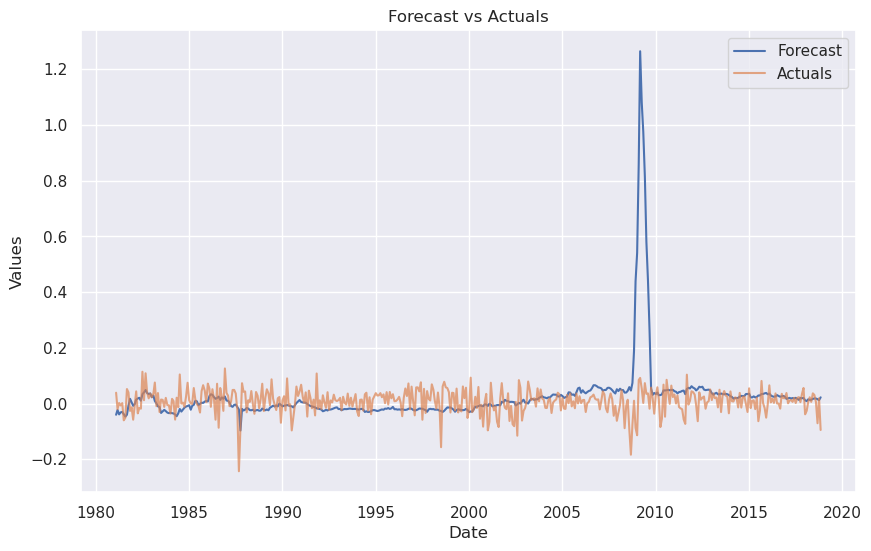

In [29]:
def ols_expanding_window_forecast(df, target_column='target', start_date='1981-01-01', test_size=0.15):
    forecasts = []
    actuals = []
    dates = df.loc[start_date:].index

    for i in range(len(dates) - 1):
        date = dates[i]
        next_date = dates[i + 1]

        df_subset = df.loc[:date]

        split_point = int(len(df_subset) * (1 - test_size))
        df_train, df_valid = df_subset.iloc[:split_point], df_subset.iloc[split_point:]

        formula = f"{target_column} ~ " + " + ".join(df.columns.difference([target_column]))
        model = ols(formula, data=df_train).fit()

        valid_predictions = model.predict(df_valid)
        valid_mse = mean_squared_error(df_valid[target_column], valid_predictions)

        forecast = model.predict(df.loc[next_date].drop(target_column).to_frame().T)[0]

        forecasts.append(forecast)
        actuals.append(df.loc[next_date][target_column])

    mspe = mean_squared_error(actuals, forecasts)
    r2 = r2_score(actuals, forecasts)

    index = df.loc[start_date:].index[1:]
    prediction_df = pd.DataFrame({
        'actual': actuals,
        'forecast': forecasts
    }, index=index)

    return prediction_df, mspe, r2

prediction_df, mspe, r2 = ols_expanding_window_forecast(post_wwii)
results_df = add_results_to_df(None, 'ols', {}, mspe, r2)
save_results(prediction_df, 'ols')
print_metrics(mspe, r2)
plot_predictions(prediction_df)

## Ridge

  0%|          | 0/454 [00:00<?, ?it/s]

Out-of-sample Mean Squared Prediction Error (MSPE): 0.001813344185788257
Out-of-sample R-squared (R²): 0.014093554160306998


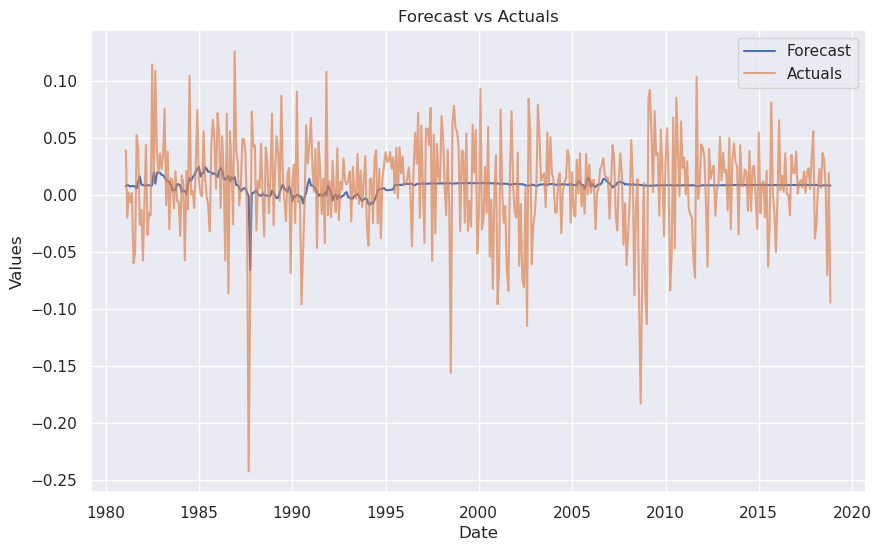

In [30]:
start_exponent = 0
end_exponent = 19
num_elements = end_exponent - start_exponent + 1

sequence = list(np.logspace(start_exponent, end_exponent, num=num_elements, base=10.0))
sequence+=list(np.arange(10, 100, 10))

param_grid = {'alpha': sequence}

prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    Ridge,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
    )
results_df = add_results_to_df(results_df, 'ridge', best_params, mspe, r2)
save_results(prediction_df, 'ridge')
print_metrics(mspe, r2)
plot_predictions(prediction_df)

##Lasso

  0%|          | 0/454 [00:00<?, ?it/s]

Out-of-sample Mean Squared Prediction Error (MSPE): 0.0018274707239581069
Out-of-sample R-squared (R²): 0.006413030703265821


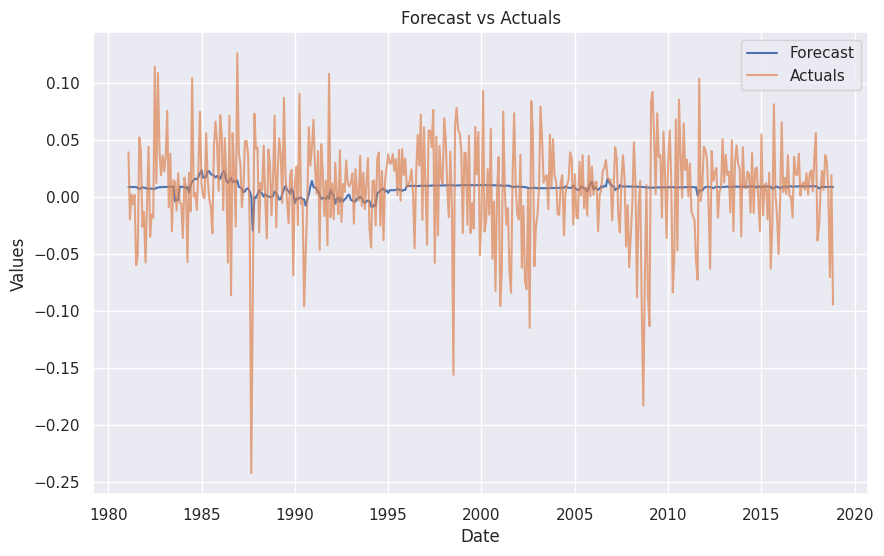

In [ ]:
start_exponent = -6
end_exponent = 0
num_elements = end_exponent - start_exponent + 1

sequence = list(np.logspace(start_exponent, end_exponent, num=num_elements, base=10.0))
sequence+=list(arange(0.001,0.01,0.001))+list(arange(0.0001,0.001,0.00002))

param_grid = {'alpha': sequence}

prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    Lasso,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
    )
print_metrics(mspe, r2)
plot_predictions(prediction_df)

##ElasticNet

  0%|          | 0/454 [00:00<?, ?it/s]

{'alpha': 10.0, 'l1_ratio': 0.0}
Out-of-sample Mean Squared Prediction Error (MSPE): 0.001815073676891378
Out-of-sample R-squared (R²): 0.01315324506718274


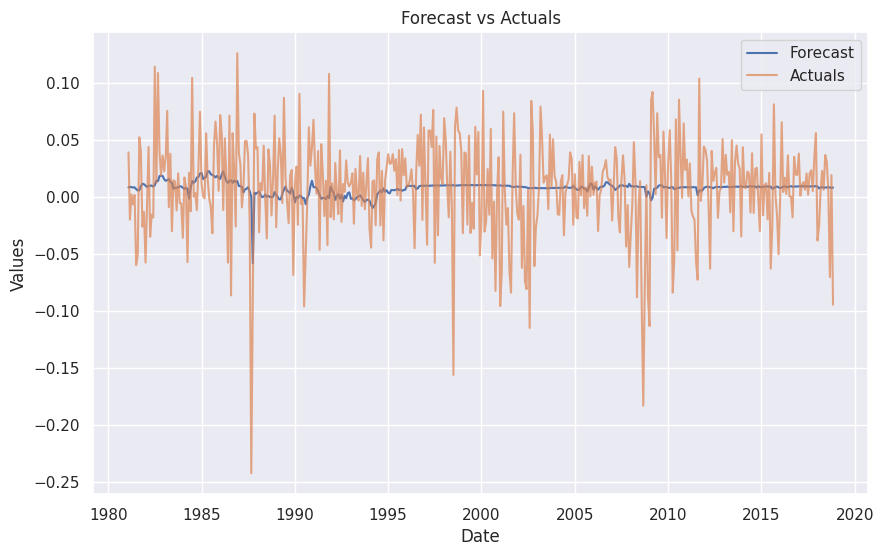

In [ ]:
start_exponent = -3
end_exponent = 3
num_elements = end_exponent - start_exponent + 1

sequence = list(np.logspace(start_exponent, end_exponent, num=num_elements, base=10.0))
sequence+=list(arange(1,10,1))

param_grid = {'alpha': sequence, 'l1_ratio': arange(0, 1, 0.1)}

prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    ElasticNet,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
    )
print(best_params)
print_metrics(mspe, r2)
plot_predictions(prediction_df)

## Random forest trees

In [36]:
from sklearn.ensemble import RandomForestRegressor

# X_train, X_test, y_train, y_test = split_data(post_wwii)
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# param_grid = {
#     'n_estimators': list(range(1, 51, 10)),
#     'random_state': [0,5,10,15,20,25,30,35,40,42]

# }
param_grid = {
    'n_estimators': [41],
    'random_state': [30]

}
prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    RandomForestRegressor,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
    )

# y_pred = rf_model.predict(X_test)

# # Calculate metrics
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

results_df = add_results_to_df(results_df, 'random_forest', best_params, mspe, r2)
save_results(prediction_df, 'random_forest')

print_metrics(mspe, r2)
plot_predictions(prediction_df)

  0%|          | 0/454 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
results_df

,model_name,params,mspe,r2
0,ols,{},0.015251,-7.291736
0,ridge,"{""alpha"": 10000.0}",0.001813,0.014094
0,random_forest,"{""n_estimators"": 21, ""random_state"": 0}",0.002213,-0.203434


In [ ]:
# feature_importances = rf_model.feature_importances_
# importance_df = pd.DataFrame({
#     'Feature': X_test.columns,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# print(importance_df)

## Boosted Regression Trees

In [ ]:
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'max_depth': [3, 5, 7, 9]
# }

param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [40, 50, 100],
    'max_depth': [5, 10]
}

prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    GradientBoostingRegressor,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
)

print_metrics(mspe, r2)
results_df = add_results_to_df(results_df, 'boosted_regression_trees', best_params, mspe, r2)
save_results(prediction_df, 'boosted_regression_trees')

plot_predictions(prediction_df)

## Extremely randomized regression trees

  0%|          | 0/454 [00:00<?, ?it/s]

{'n_estimators': 10, 'max_depth': 10}
Out-of-sample Mean Squared Prediction Error (MSPE): 0.0019214522081146305
Out-of-sample R-squared (R²): -0.04468425365681239


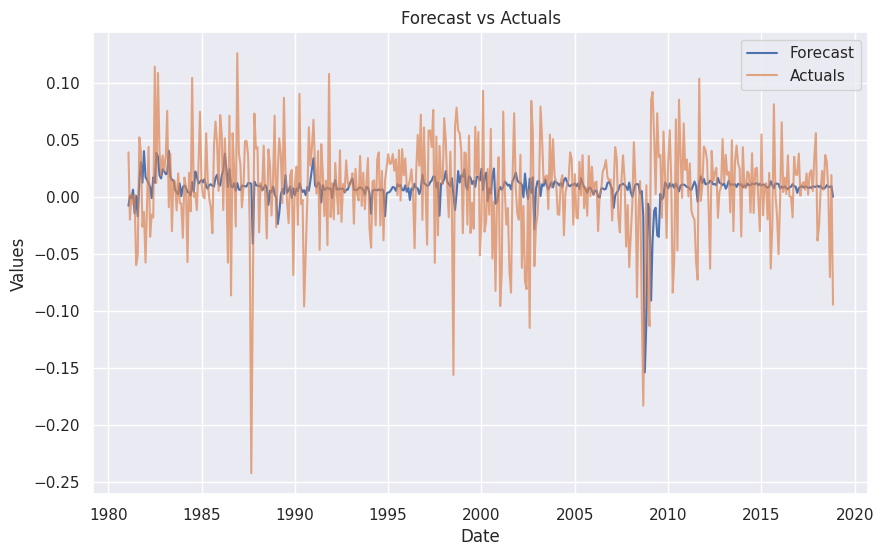

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
# param_grid = {'n_estimators': [10, 25, 50], 'max_depth': [5, 10, 15]}

# I decreased this stuff from logs
param_grid = {'n_estimators': [50], 'max_depth': [5]}


prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    ExtraTreesRegressor,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
    )
print(best_params)
print_metrics(mspe, r2)
plot_predictions(prediction_df)
save_results(prediction_df, 'extremely_randomized')

results_df = add_results_to_df(results_df, 'extremely_randomized', best_params, mspe, r2)


## NN

In [75]:
import torch
from torch import nn, optim
import torch.utils.data as D



class NeuralNetwork:

    def __init__(
            self, lr, epochs, batch_size, optimizer,
            device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = self.init_network()
        self.device = device
        self.model.to(self.device)
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr

        self.optimizer = optimizer(
            self.model.parameters(),
            self.lr)
        self.loss = nn.MSELoss()

    def init_network(self):
        return nn.Sequential(
            nn.Linear(12, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def fit(self, X, y):
        loader = D.DataLoader(
            list(zip(torch.tensor(X,dtype=torch.float32).to(self.device), torch.tensor(y, dtype=torch.float32).to(self.device))),
            shuffle=False,
            batch_size=self.batch_size)
        for _ in trange(self.epochs, desc='Training model', disable=True):
            for x_batched, y_batched in loader:

                y_batched_predicted = self.model(x_batched)
                output = self.loss(y_batched, y_batched_predicted)

                output.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()



    def predict(self, X):
        with torch.no_grad():
            res =  self.model(torch.tensor(X, dtype=torch.float32).to(self.device)).cpu().numpy()
            return res.squeeze(-1)


class DeepNN(NeuralNetwork):

    def init_network(self):
        return nn.Sequential(
            nn.Linear(12, 16),
            nn.Tanh(),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Linear(8,1),
        )


### Shallow NN

  0%|          | 0/454 [00:00<?, ?it/s]

Best params for NeuralNetwork are {'lr': 0.1, 'epochs': 20, 'batch_size': 64, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Out-of-sample Mean Squared Prediction Error (MSPE): 0.0036643879505002855
Out-of-sample R-squared (R²): -0.9923099700375311


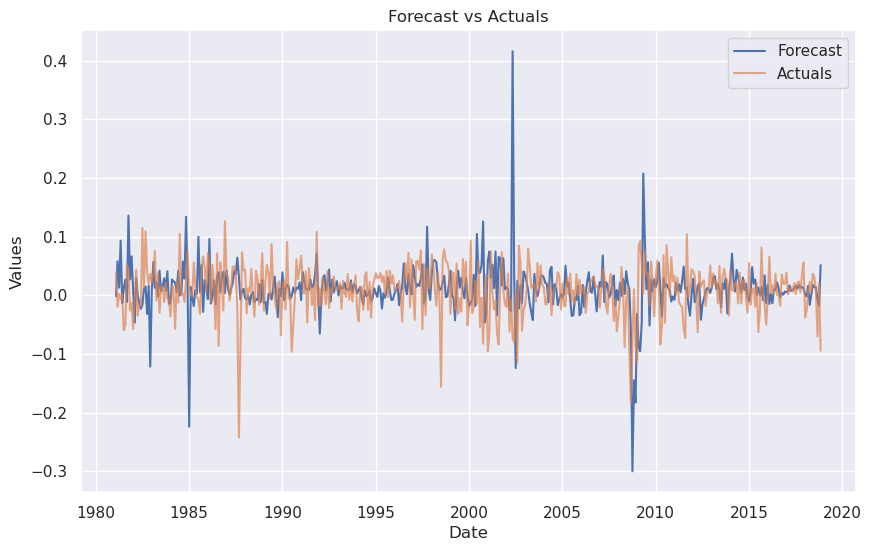

In [82]:
param_grid = {'lr': [1e-1, 1e-5], 'epochs': [2, 20, 50], 'batch_size': [64],
              'optimizer': [optim.SGD]}
prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    NeuralNetwork,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
    )
# results_df = add_results_to_df(results_df, 'shallow_nn', best_params, mspe, r2)
# save_results(prediction_df, 'shallow_nn')
print_metrics(mspe, r2)
plot_predictions(prediction_df)

### Deep NN

  0%|          | 0/454 [00:00<?, ?it/s]

Best params for DeepNN are {'lr': 0.1, 'epochs': 10, 'batch_size': 128}
Out-of-sample Mean Squared Prediction Error (MSPE): 0.011053126639162626
Out-of-sample R-squared (R²): -5.009531387167847


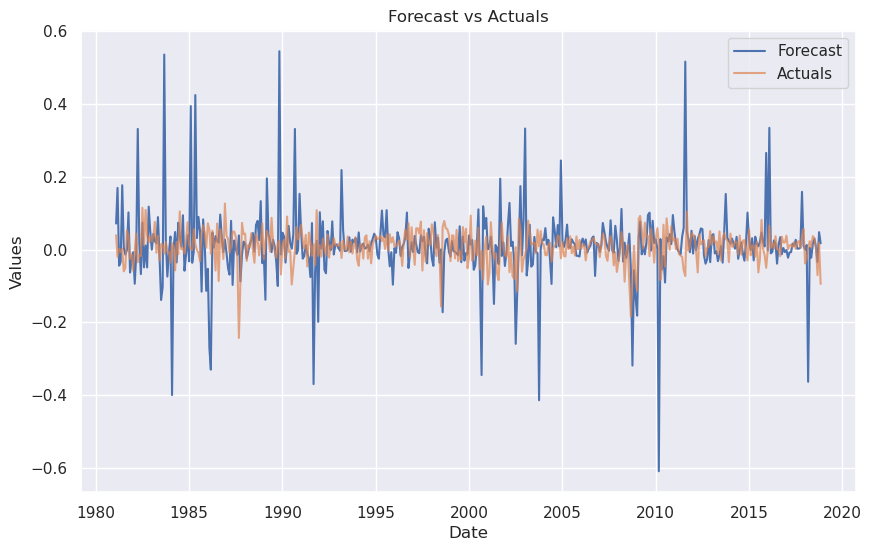

In [72]:
param_grid = {'lr': [1e-1, 1e-3, 1e-4, 1e-5], 'epochs': [2, 5, 10], 'batch_size': [128]}

prediction_df, best_params, mspe, r2 = expanding_window_forecasts_with_custom_gridsearch(
    post_wwii,
    DeepNN,
    param_grid=param_grid,
    normalize_data=True,
    scoring_function=negative_r2
    )
# results_df = add_results_to_df(results_df, 'deep_nn', best_params, mspe, r2)
save_results(prediction_df, 'deep_nn')

print_metrics(mspe, r2)
plot_predictions(prediction_df)

## PCA

In [78]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


def get_pca_pipeline(n_components):
    return Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=n_components)),
    ('regressor', LinearRegression())
])


def fit_and_rolling_predict(model, df,
        target_column='target',
        start_date='1981-01-01'):

    X = df.drop(columns=target_column)
    y = df[target_column]

    X = X.sort_index()
    n_periods = len(X.loc[start_date:])

    actuals = []
    forecasts = []

    for i in trange(n_periods - 1):
        current_date_idx = X.index.get_loc(start_date) + i

        in_sample_X = X.iloc[:current_date_idx]
        in_sample_y = y.iloc[:current_date_idx]
        model.fit(in_sample_X, in_sample_y)

        forecast_features = X.iloc[current_date_idx].values.reshape(1, -1)
        y_pred = model.predict(forecast_features).squeeze()

        actuals.append(y.iloc[current_date_idx])
        forecasts.append(y_pred)

    df =  get_prediction_df_from_numpy(
        np.array(actuals), np.array(forecasts),
        index=X.iloc[X.index.get_loc(start_date) + 1:].index # im not sure if its true
    )
    return df

def compute_metrics(y_true, y_pred, metrics=[r2_score, mean_squared_error]):
    return {
        score_func.__name__ : score_func(y_true, y_pred)
        for score_func in metrics
    }

def get_prediction_df_from_numpy(y_true, y_pred, index):
    return pd.DataFrame({
        'actual': y_true,
        'forecast': y_pred
    }, index=index)


  0%|          | 0/454 [00:00<?, ?it/s]

{'r2_score': -0.016520083167076427, 'mean_squared_error': 0.0018459556917002323}
pca_with_3_components


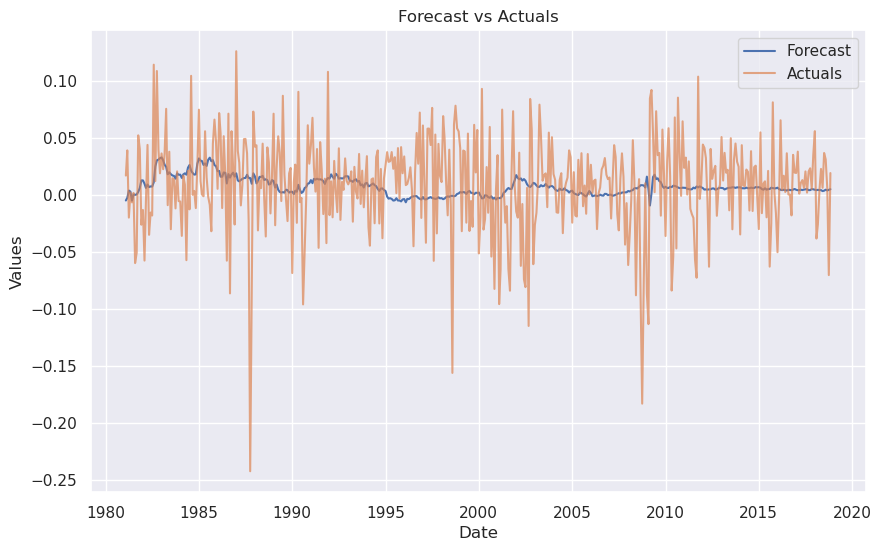

  0%|          | 0/454 [00:00<?, ?it/s]

{'r2_score': -0.044968670091297236, 'mean_squared_error': 0.0018976170723489828}
pca_with_5_components


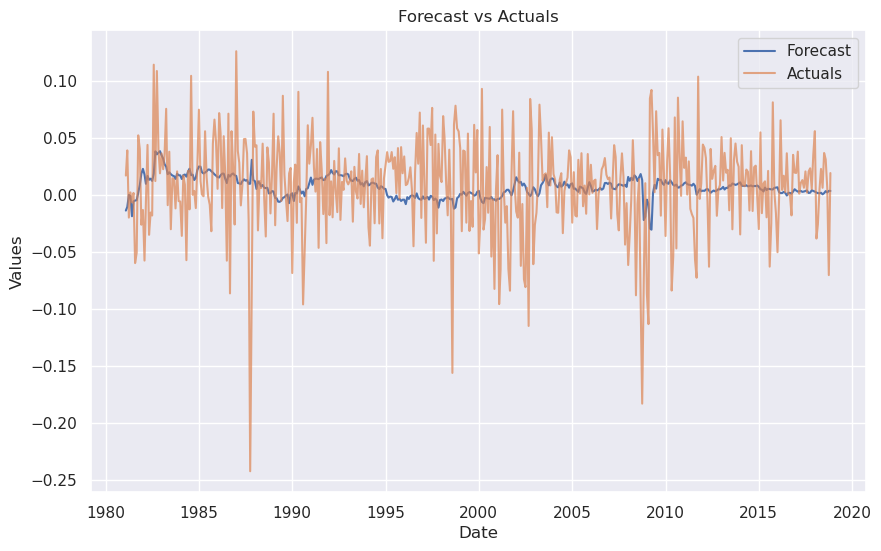

  0%|          | 0/454 [00:00<?, ?it/s]

{'r2_score': -0.05170775307754627, 'mean_squared_error': 0.0019098549501846557}
pca_with_10_components


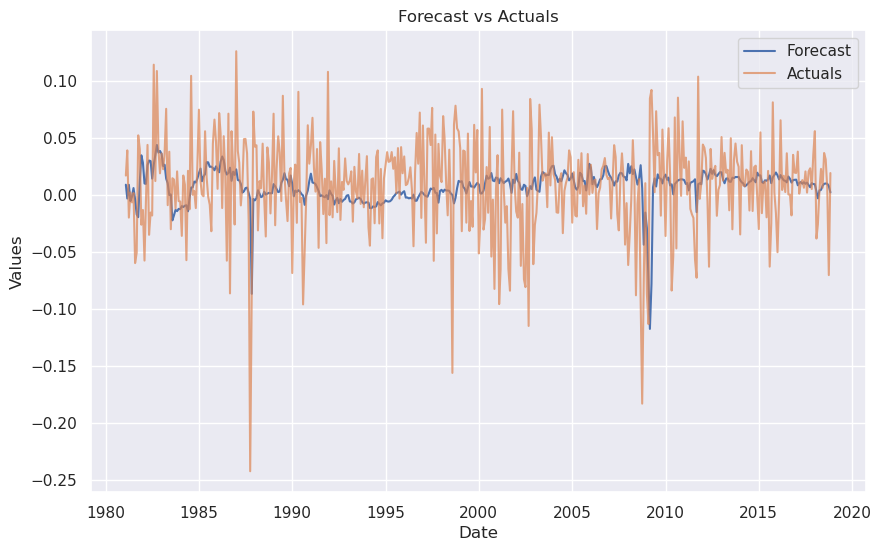

In [81]:
for n_components in [3, 5, 10]:
    pipe = get_pca_pipeline(n_components)
    res_df = fit_and_rolling_predict(pipe, post_wwii)
    print(compute_metrics(res_df.actual, res_df.forecast))
    name = 'pca_with_{}_components'.format(n_components)
    print(name)
    # results_df = add_results_to_df(results_df, name, {
    #     'n_components': n_components
    # }, mean_squared_error(res_df.actual, res_df.forecast), r2_score(res_df.actual, res_df.forecast))
    save_results(prediction_df, name)

    plot_predictions(res_df)


In [ ]:
results_df.to_csv('results.csv')